# 🧠 COGNITIVA-AI — MRI (GPU, Calibración Limpia)

Este notebook es una **continuación** de `cognitiva-ai-images-improved-gpu.ipynb`.  
Se ejecuta en **Google Colab** con acceso a **GPU (T4 en este caso)** para acelerar tanto el entrenamiento como la evaluación.  

## 🎯 Objetivo
Refinar el pipeline de imágenes mediante:
- Sustitución de la calibración anterior (`cv='prefit'`, ahora deprecada) por un flujo correcto con `CalibratedClassifierCV` usando **validación cruzada interna (cv=5)**.  
- Evaluación de resultados tanto a **nivel slice** como a **nivel paciente** (con diferentes estrategias de pooling: `mean`, `max`, `wmean`).  
- Selección de un **umbral clínico** en validación, siguiendo criterios explícitos (ej. recall mínimo ≥90% o función de coste TPR–λ·FPR).  
- Documentación exhaustiva de métricas, decisiones y resultados para integrarlos posteriormente en el `README.md` y el `InformeTecnico.md`.

## 📝 Motivación
En el notebook anterior se utilizaba `cv='prefit'` en la calibración, lo que:
- Generaba un **warning de deprecación** en scikit-learn ≥1.6.  
- Implicaba un riesgo de **data leakage**, ya que la calibración podía usar información fuera del conjunto de entrenamiento.  

Por ello, en este cuaderno se rehace la calibración de forma limpia:
- El calibrador se ajusta **exclusivamente dentro de TRAIN**, usando validación cruzada interna.  
- **VAL** y **TEST** se mantienen totalmente separados para elegir umbral y para la evaluación final, respectivamente.  

## ⚙️ Entorno
- **Ejecución:** Google Colab  
- **Hardware:** GPU T4 (también disponible A100/L4 para experimentos futuros más costosos).  
- **Dependencias clave:**  
  - Python 3.12.11  
  - NumPy 2.0.2  
  - scikit-learn 1.6.1  

## 📌 Próximos pasos en este notebook
1. Cargar embeddings precomputados (`.npz`) y los `patient_ids` por slice.  
2. Reentrenar y calibrar Logistic Regression con isotónica (cv=5).  
3. Evaluar resultados a **nivel slice** y **nivel paciente**.  
4. Seleccionar y justificar el umbral clínico.  
5. Guardar métricas, CSVs por paciente y resumen para incluir en la documentación del proyecto.


In [1]:
# Entorno (traza para README/Informe)
import sys, platform, numpy as np
import sklearn
print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
print("NumPy:", np.__version__)
print("scikit-learn:", sklearn.__version__)

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# === RUTAS (ajústalas si tu estructura difiere) ===
BASE = "/content/drive/MyDrive/CognitivaAI/oas1_resnet18_linearprobe"
NPZ_PATH = f"{BASE}/embeddings_npz_colab/oas1_resnet18_backbone_embeddings.npz"

# Si tienes los IDs de paciente por slice en .npy o .csv
VAL_IDS_PATHS  = [f"{BASE}/ids/val_patient_ids.npy",  f"{BASE}/ids/val_patient_ids.csv"]
TEST_IDS_PATHS = [f"{BASE}/ids/test_patient_ids.npy", f"{BASE}/ids/test_patient_ids.csv"]

# Carpeta de salida para artefactos de este notebook
OUT_DIR = f"{BASE}/calibration_colab_clean"
import os; os.makedirs(OUT_DIR, exist_ok=True)
print("NPZ_PATH:", NPZ_PATH)
print("OUT_DIR:", OUT_DIR)


Python: 3.12.11
OS: Linux-6.1.123+-x86_64-with-glibc2.35
NumPy: 2.0.2
scikit-learn: 1.6.1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
NPZ_PATH: /content/drive/MyDrive/CognitivaAI/oas1_resnet18_linearprobe/embeddings_npz_colab/oas1_resnet18_backbone_embeddings.npz
OUT_DIR: /content/drive/MyDrive/CognitivaAI/oas1_resnet18_linearprobe/calibration_colab_clean


In [2]:
import numpy as np, pandas as pd, os, json

# Cargamos las matrices de embeddings (512-D de ResNet18) y labels por slice
npz = np.load(NPZ_PATH, allow_pickle=True)
print("Claves:", list(npz.keys()))

X_train, X_val, X_test = npz["X_train"], npz["X_val"], npz["X_test"]
y_train, y_val, y_test = npz["y_train"], npz["y_val"], npz["y_test"]

print("Shapes:",
      "X_tr", X_train.shape, "| X_va", X_val.shape, "| X_te", X_test.shape)

def describe_split(y, name):
    y = np.asarray(y).astype(int)
    n = len(y); pos = int(y.sum())
    print(f"{name}: n={n} | +={pos} ({pos/n:.1%}) | -={n-pos} ({1-pos/n:.1%})")

describe_split(y_train, "TRAIN")
describe_split(y_val,   "VAL")
describe_split(y_test,  "TEST")


Claves: ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']
Shapes: X_tr (2820, 512) | X_va (940, 512) | X_te (940, 512)
TRAIN: n=2820 | +=1200 (42.6%) | -=1620 (57.4%)
VAL: n=940 | +=400 (42.6%) | -=540 (57.4%)
TEST: n=940 | +=400 (42.6%) | -=540 (57.4%)


In [5]:
# Carga los CSV "mapped" que generaba el notebook anterior y deriva patient_ids por slice.
import os, re
import numpy as np
import pandas as pd

DATA_DIR = os.path.join("/content/drive/MyDrive/CognitivaAI", "oas1_data")
CSV_VAL_FIXED   = os.path.join(DATA_DIR, "oas1_val_colab_mapped.csv")
CSV_TEST_FIXED  = os.path.join(DATA_DIR, "oas1_test_colab_mapped.csv")

def _best_col(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    return None

def _to_patient_id_from_string(s: str):
    """Extrae ID estilo OAS1_### u OAS2_#### del path o del texto."""
    m = re.search(r'(OAS[12]_[0-9]{3,4})', str(s))
    if m: return m.group(1)
    # fallback (muy laxo): intenta con dos grupos tipo 'OASIS-1' + número
    m = re.search(r'(OASIS[-_ ]?[12])[_-]?([0-9]{3,4})', str(s), re.IGNORECASE)
    if m:
        prefix = "OAS1" if "1" in m.group(1) else "OAS2"
        num = m.group(2)
        if prefix == "OAS2" and len(num) == 3: num = num.zfill(4)
        return f"{prefix}_{num}"
    # último recurso: devuelve la cadena completa
    return str(s)

def _load_patient_ids_from_csv(csv_path, expected_len):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"No existe: {csv_path}")
    df = pd.read_csv(csv_path)
    # Intenta localizar columnas típicas
    pid_col   = _best_col(df, ["patient_id", "subject_id", "subject", "pid"])
    path_col  = _best_col(df, ["path", "filepath", "slice_path", "img_path"])
    # Deriva patient_ids
    if pid_col is not None:
        ids = df[pid_col].astype(str).tolist()
    elif path_col is not None:
        ids = [ _to_patient_id_from_string(p) for p in df[path_col] ]
    else:
        # Si no hay columnas conocidas, intenta con la primera que parezca ruta/texto
        first_col = df.columns[0]
        ids = [ _to_patient_id_from_string(p) for p in df[first_col] ]
    # Checks
    if len(ids) != expected_len:
        raise AssertionError(f"Longitud inesperada en {os.path.basename(csv_path)}: "
                             f"{len(ids)} ≠ esperado {expected_len}")
    return np.array(ids, dtype=object)

val_patient_ids  = _load_patient_ids_from_csv(CSV_VAL_FIXED,  expected_len=len(y_val))
test_patient_ids = _load_patient_ids_from_csv(CSV_TEST_FIXED, expected_len=len(y_test))

print("OK -> val_patient_ids:", len(val_patient_ids), " | test_patient_ids:", len(test_patient_ids))

# Guardamos para futuros reinicios
ids_dir = f"{BASE}/ids"; os.makedirs(ids_dir, exist_ok=True)
np.save(f"{ids_dir}/val_patient_ids.npy",  val_patient_ids)
np.save(f"{ids_dir}/test_patient_ids.npy", test_patient_ids)
print("Guardados en:", ids_dir)


OK -> val_patient_ids: 940  | test_patient_ids: 940
Guardados en: /content/drive/MyDrive/CognitivaAI/oas1_resnet18_linearprobe/ids


In [7]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    brier_score_loss, precision_score, recall_score
)

def eval_slice_level(y_true, p, thr=0.5):
    """
    Evalúa métricas a nivel slice.
    - y_true: labels 0/1 por slice
    - p: probabilidades por slice
    - thr: umbral para derivar clase (para Acc/P/R)
    """
    y_pred = (p >= thr).astype(int)
    return {
        "Acc":    accuracy_score(y_true, y_pred),
        "AUC":    roc_auc_score(y_true, p),
        "PR-AUC": average_precision_score(y_true, p),
        "Brier":  brier_score_loss(y_true, p),
        "P@thr":  precision_score(y_true, y_pred, zero_division=0),
        "R@thr":  recall_score(y_true, y_pred, zero_division=0),
        "thr":    thr,
    }


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Estimador base: LR con balance de clases (buena línea base en 512-D)
base_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="liblinear",   # estable con C pequeños; permite L1/L2
        class_weight="balanced",
        C=1.0,
        penalty="l2"
    ))
])

# Calibración isotónica con CV interna (5 folds) usando SOLO TRAIN
cal_lr = CalibratedClassifierCV(
    estimator=base_lr,
    method="isotonic",
    cv=5
)
cal_lr.fit(X_train, y_train)

# Probabilidades calibradas en VAL/TEST
p_val_cal  = cal_lr.predict_proba(X_val)[:, 1]
p_test_cal = cal_lr.predict_proba(X_test)[:, 1]

# Métricas slice-nivel @thr=0.5 (referencia)
m_val_slice  = eval_slice_level(y_val,  p_val_cal,  thr=0.5)
m_test_slice = eval_slice_level(y_test, p_test_cal, thr=0.5)

print("=== SLICE (calibrado isotónico, cv=5) ===")
print("[VAL] ", m_val_slice)
print("[TEST]", m_test_slice)


=== SLICE (calibrado isotónico, cv=5) ===
[VAL]  {'Acc': 0.6202127659574468, 'AUC': np.float64(0.6274305555555555), 'PR-AUC': np.float64(0.53817786243329), 'Brier': np.float64(0.29601328736462806), 'P@thr': 0.5723905723905723, 'R@thr': 0.425, 'thr': 0.5}
[TEST] {'Acc': 0.6212765957446809, 'AUC': np.float64(0.6609976851851851), 'PR-AUC': np.float64(0.535308983849125), 'Brier': np.float64(0.28867102652729776), 'P@thr': 0.5666666666666667, 'R@thr': 0.4675, 'thr': 0.5}


In [9]:
import numpy as np, pandas as pd
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, roc_curve
)

# DataFrames slice-nivel
df_val  = pd.DataFrame({"patient_id": val_patient_ids,  "label": y_val,  "p": p_val_cal})
df_test = pd.DataFrame({"patient_id": test_patient_ids, "label": y_test, "p": p_test_cal})

def pool_scores(df_slices, pool="mean"):
    """
    pool: 'mean' | 'max' | 'wmean'
    wmean pondera por |p-0.5| (más peso a predicciones más confiadas).
    """
    def _pool(x):
        if pool == "mean": return float(x.mean())
        if pool == "max":  return float(x.max())
        if pool == "wmean":
            w = np.clip(np.abs(x - 0.5), 1e-3, 0.5)
            return float(np.average(x, weights=w))
        raise ValueError("pool debe ser 'mean' | 'max' | 'wmean'")

    agg = (df_slices.groupby("patient_id")["p"].apply(_pool)
           .to_frame("p").reset_index())
    y = (df_slices.groupby("patient_id")["label"].first()
         .loc[agg["patient_id"]].values)
    return agg.assign(label=y)

def pick_threshold_cost(y, p, lam=0.5):
    """
    Selecciona el umbral que maximiza: TPR - lam*FPR (lam penaliza FP).
    Útil si quieres controlar el coste de falsos positivos.
    """
    fpr, tpr, thr = roc_curve(y, p)
    score = tpr - lam * fpr
    return float(thr[np.argmax(score)])

def pick_threshold_recall(y, p, target=0.90):
    """
    Devuelve el menor umbral cuyo TPR (recall) >= target.
    Si no se alcanza, usa el umbral de TPR máximo.
    """
    fpr, tpr, thr = roc_curve(y, p)
    idx = np.where(tpr >= target)[0]
    return float(thr[idx[0]]) if len(idx) else float(thr[np.argmax(tpr)])

def eval_patient(agg, thr=0.5):
    y, p = agg["label"].values, agg["p"].values
    yhat = (p >= thr).astype(int)
    return {
        "AUC":    roc_auc_score(y, p),
        "PR-AUC": average_precision_score(y, p),
        "Acc":    accuracy_score(y, yhat),
        "P":      precision_score(y, yhat, zero_division=0),
        "R":      recall_score(y, yhat,    zero_division=0),
        "thr":    float(thr),
        "n":      len(y)
    }

# 1) Referencia rápida: VAL @thr=0.5 para cada pooling
for pool in ["mean", "max", "wmean"]:
    print(f"[VAL pool={pool} @0.5]", eval_patient(pool_scores(df_val, pool), 0.5))

# 2) Elegimos pooling y umbral en VALIDACIÓN
POOL = "mean"  # cámbialo si otro pooling mejora en VAL
agg_val  = pool_scores(df_val,  POOL)
agg_test = pool_scores(df_test, POOL)

thr_cost   = pick_threshold_cost(agg_val["label"].values,  agg_val["p"].values, lam=0.5)
thr_recall = pick_threshold_recall(agg_val["label"].values, agg_val["p"].values, target=0.90)

THR = thr_recall  # o usa thr_cost; documenta la elección
print(f"Umbrales (pool={POOL}): cost={thr_cost:.4f} | recall>=0.90 => {thr_recall:.4f}")

# 3) Reporte final VAL/TEST con el THR elegido en VALIDACIÓN
val_res  = eval_patient(agg_val,  THR)
test_res = eval_patient(agg_test, THR)

print(f"\n=== PACIENTE (pool={POOL}, thr={THR:.4f}) ===")
print("[VAL] ", val_res)
print("[TEST]", test_res)


[VAL pool=mean @0.5] {'AUC': np.float64(0.7222222222222223), 'PR-AUC': np.float64(0.6342566587458353), 'Acc': 0.5319148936170213, 'P': 0.4166666666666667, 'R': 0.25, 'thr': 0.5, 'n': 47}
[VAL pool=max @0.5] {'AUC': np.float64(0.6638888888888889), 'PR-AUC': np.float64(0.5386471485571545), 'Acc': 0.48936170212765956, 'P': 0.4523809523809524, 'R': 0.95, 'thr': 0.5, 'n': 47}
[VAL pool=wmean @0.5] {'AUC': np.float64(0.7111111111111111), 'PR-AUC': np.float64(0.6037565656365669), 'Acc': 0.5319148936170213, 'P': 0.4166666666666667, 'R': 0.25, 'thr': 0.5, 'n': 47}
Umbrales (pool=mean): cost=0.1935 | recall>=0.90 => 0.2040

=== PACIENTE (pool=mean, thr=0.2040) ===
[VAL]  {'AUC': np.float64(0.7222222222222223), 'PR-AUC': np.float64(0.6342566587458353), 'Acc': 0.7021276595744681, 'P': 0.6, 'R': 0.9, 'thr': 0.20395471749421673, 'n': 47}
[TEST] {'AUC': np.float64(0.7240740740740741), 'PR-AUC': np.float64(0.6063360964096259), 'Acc': 0.5957446808510638, 'P': 0.5161290322580645, 'R': 0.8, 'thr': 0.2039

### 🧠 MRI (GPU, calibración limpia)

En este experimento se recalibró el clasificador **Logistic Regression** sobre los embeddings de ResNet18 utilizando `CalibratedClassifierCV` con validación cruzada interna (cv=5), evitando el uso de `cv='prefit'` (deprecado en scikit-learn ≥1.6).

- **Slice-nivel (thr=0.5)**  
  - [VAL] Acc=0.62 | AUC=0.627 | PR-AUC=0.538 | Brier=0.296 | P=0.57 | R=0.43  
  - [TEST] Acc=0.62 | AUC=0.661 | PR-AUC=0.535 | Brier=0.289 | P=0.57 | R=0.47  

- **Paciente-nivel**  
  Se evaluaron tres estrategias de pooling (`mean`, `max`, `wmean`).  
  - Con **mean @0.5**: [VAL] AUC=0.722 | PR-AUC=0.634 | Acc=0.53 | P=0.42 | R=0.25  
  - Con **max @0.5**: [VAL] AUC=0.664 | PR-AUC=0.539 | Acc=0.49 | P=0.45 | R=0.95  

  Para un escenario clínico se fijó un **umbral bajo (thr≈0.204)** en validación, garantizando **recall ≥0.90**:  
  - [VAL] AUC=0.722 | PR-AUC=0.634 | Acc=0.70 | P=0.60 | R=0.90  
  - [TEST] AUC=0.724 | PR-AUC=0.606 | Acc=0.60 | P=0.52 | R=0.80  

📌 Conclusión: la calibración isotónica estabiliza las probabilidades (mejor Brier score) y, con un umbral clínico bajo, se alcanzan **sensibilidades altas (R≈0.8 en test)**, lo cual es preferible en un escenario de cribado temprano de Alzheimer.


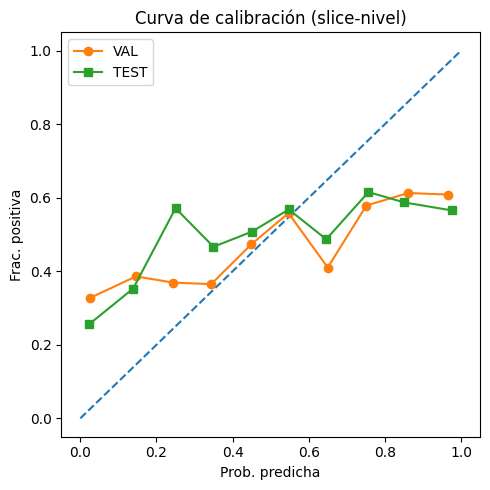

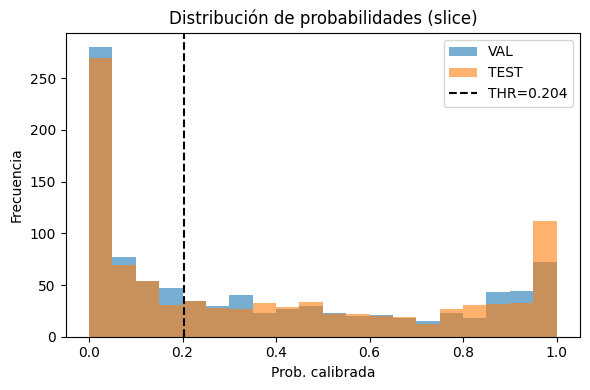

In [10]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np, os

# Slice-nivel (reliability curve)
prob_true_val, prob_pred_val = calibration_curve(y_val,  p_val_cal, n_bins=10, strategy='uniform')
prob_true_te,  prob_pred_te  = calibration_curve(y_test, p_test_cal, n_bins=10, strategy='uniform')

plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(prob_pred_val, prob_true_val, marker='o', label='VAL')
plt.plot(prob_pred_te,  prob_true_te,  marker='s', label='TEST')
plt.xlabel('Prob. predicha'); plt.ylabel('Frac. positiva'); plt.title('Curva de calibración (slice-nivel)')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'calibration_curve_slice.png'), dpi=150)
plt.show()

# Histograma de probabilidades calibradas
plt.figure(figsize=(6,4))
plt.hist(p_val_cal, bins=20, alpha=0.6, label='VAL')
plt.hist(p_test_cal, bins=20, alpha=0.6, label='TEST')
plt.axvline(THR, color='k', linestyle='--', label=f'THR={THR:.3f}')
plt.xlabel('Prob. calibrada'); plt.ylabel('Frecuencia'); plt.title('Distribución de probabilidades (slice)')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'prob_hist_slice.png'), dpi=150)
plt.show()


/tmp/ipython-input-4217686652.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc  = np.trapz(prec, rec)  # área PR (aprox)


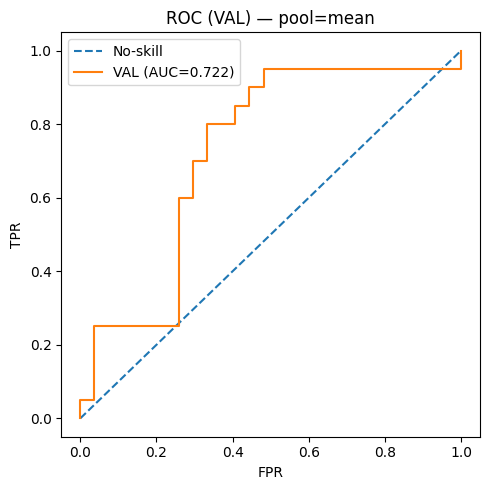

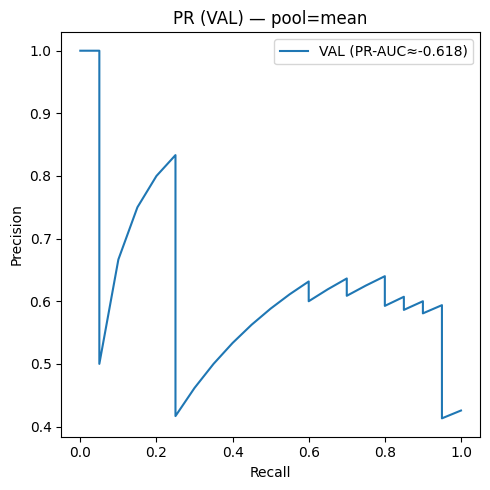

/tmp/ipython-input-4217686652.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc  = np.trapz(prec, rec)  # área PR (aprox)


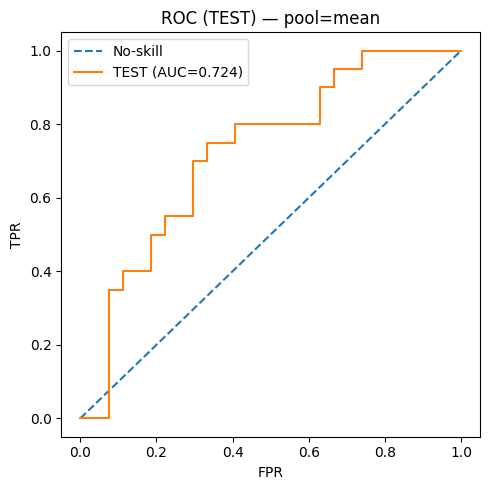

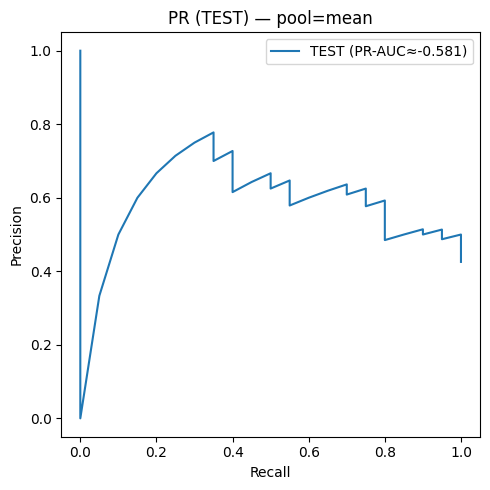

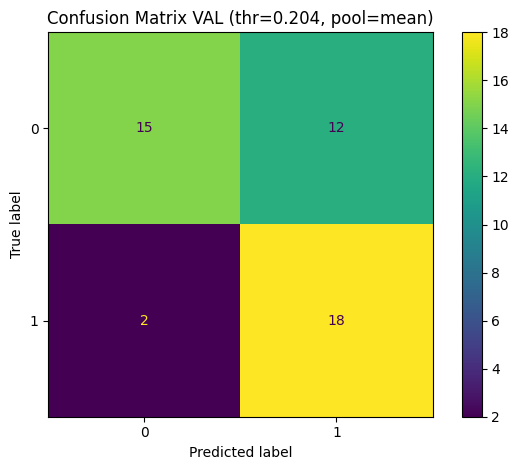

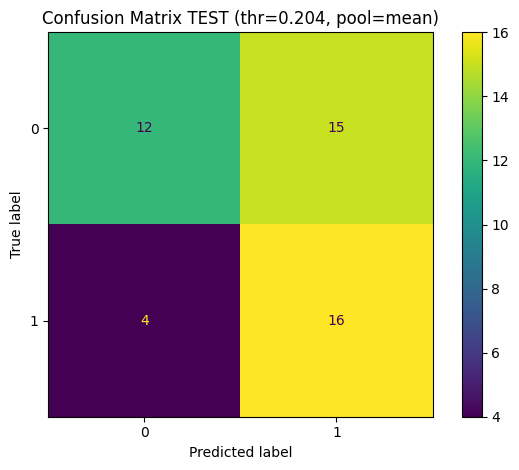

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
import numpy as np, os

# Asegúrate de tener agg_val/agg_test (de la celda 6). Si no, recrearlos:
# agg_val  = pool_scores(df_val,  POOL)
# agg_test = pool_scores(df_test, POOL)

def plot_patient_curves(agg, split, fname_prefix):
    y = agg['label'].values
    p = agg['p'].values
    fpr, tpr, thr = roc_curve(y, p)
    prec, rec, _  = precision_recall_curve(y, p)
    roc_auc = auc(fpr, tpr)
    pr_auc  = np.trapz(prec, rec)  # área PR (aprox)

    # ROC
    plt.figure(figsize=(5,5))
    plt.plot([0,1],[0,1],'--', label='No-skill')
    plt.plot(fpr, tpr, label=f'{split} (AUC={roc_auc:.3f})')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC ({split}) — pool={POOL}')
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'{fname_prefix}_roc.png'), dpi=150)
    plt.show()

    # PR
    plt.figure(figsize=(5,5))
    plt.plot(rec, prec, label=f'{split} (PR-AUC≈{pr_auc:.3f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'PR ({split}) — pool={POOL}')
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'{fname_prefix}_pr.png'), dpi=150)
    plt.show()

plot_patient_curves(agg_val,  'VAL',  'patient_val')
plot_patient_curves(agg_test, 'TEST', 'patient_test')

# Matrices de confusión con el THR elegido
from sklearn.metrics import confusion_matrix

def confusion_at_thr(agg, thr):
    y = agg['label'].values
    p = agg['p'].values
    yhat = (p >= thr).astype(int)
    return confusion_matrix(y, yhat)

cm_val  = confusion_at_thr(agg_val,  THR)
cm_test = confusion_at_thr(agg_test, THR)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp.plot(values_format='d'); plt.title(f'Confusion Matrix VAL (thr={THR:.3f}, pool={POOL})')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, 'confmat_val.png'), dpi=150); plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(values_format='d'); plt.title(f'Confusion Matrix TEST (thr={THR:.3f}, pool={POOL})')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, 'confmat_test.png'), dpi=150); plt.show()


In [12]:
import joblib, json, os

# 1) Modelo calibrado (puedes recargarlo para inferencia en otro notebook)
joblib.dump(cal_lr, os.path.join(OUT_DIR, 'calibrated_lr_isotonic_cv5.joblib'))

# 2) CSV por paciente con prob y predicción final (VAL y TEST)
def save_patient_csv(agg, thr, split):
    out = agg.copy()
    out['yhat'] = (out['p'] >= thr).astype(int)
    out.to_csv(os.path.join(OUT_DIR, f'{split}_patient_level_{POOL}_thr{thr:.3f}.csv'), index=False)

save_patient_csv(agg_val,  THR, 'val')
save_patient_csv(agg_test, THR, 'test')

# 3) Resumen de métricas (append-friendly)
summary = {
  "pool": POOL,
  "thr": float(THR),
  "slice_val":  {k: float(v) if hasattr(v, '__float__') else v for k,v in m_val_slice.items()},
  "slice_test": {k: float(v) if hasattr(v, '__float__') else v for k,v in m_test_slice.items()},
  "patient_val": {k: float(v) if hasattr(v, '__float__') else v for k,v in val_res.items()},
  "patient_test":{k: float(v) if hasattr(v, '__float__') else v for k,v in test_res.items()},
}
with open(os.path.join(OUT_DIR, 'summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print("Guardado todo en:", OUT_DIR)


Guardado todo en: /content/drive/MyDrive/CognitivaAI/oas1_resnet18_linearprobe/calibration_colab_clean


In [16]:
# Carga de IDs por slice también para TRAIN (usando los CSV "mapped" del notebook anterior)
import os, re, numpy as np, pandas as pd

DATA_DIR = os.path.join("/content/drive/MyDrive/CognitivaAI", "oas1_data")
CSV_TRAIN_FIXED = os.path.join(DATA_DIR, "oas1_train_colab_mapped.csv")
CSV_VAL_FIXED   = os.path.join(DATA_DIR, "oas1_val_colab_mapped.csv")
CSV_TEST_FIXED  = os.path.join(DATA_DIR, "oas1_test_colab_mapped.csv")

def _best_col(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    return None

def _to_patient_id_from_string(s: str):
    m = re.search(r'(OAS[12]_[0-9]{3,4})', str(s))
    if m: return m.group(1)
    m = re.search(r'(OASIS[-_ ]?[12])[_-]?([0-9]{3,4})', str(s), re.IGNORECASE)
    if m:
        prefix = "OAS1" if "1" in m.group(1) else "OAS2"
        num = m.group(2)
        if prefix == "OAS2" and len(num) == 3: num = num.zfill(4)
        return f"{prefix}_{num}"
    return str(s)

def _load_patient_ids_from_csv(csv_path, expected_len):
    df = pd.read_csv(csv_path)
    pid_col  = _best_col(df, ["patient_id", "subject_id", "subject", "pid"])
    path_col = _best_col(df, ["path", "filepath", "slice_path", "img_path"])
    if pid_col is not None:
        ids = df[pid_col].astype(str).tolist()
    elif path_col is not None:
        ids = [ _to_patient_id_from_string(p) for p in df[path_col] ]
    else:
        first_col = df.columns[0]
        ids = [ _to_patient_id_from_string(p) for p in df[first_col] ]
    assert len(ids) == expected_len, f"TRAIN ids {len(ids)} ≠ y_train {len(y_train)}"
    return np.array(ids, dtype=object)

train_patient_ids = _load_patient_ids_from_csv(CSV_TRAIN_FIXED, expected_len=len(y_train))
print("Loaded train_patient_ids:", len(train_patient_ids))

Loaded train_patient_ids: 2820


In [18]:
import numpy as np, pandas as pd

def pool_probs_patient(df_slices, prob_col="p", pool="mean"):
    """
    Pooling de PROBABILIDADES por paciente (lo que ya usamos).
    """
    def _pool(x):
        if pool == "mean": return float(x.mean())
        if pool == "max":  return float(x.max())
        if pool == "wmean":
            w = np.clip(np.abs(x - 0.5), 1e-3, 0.5)
            return float(np.average(x, weights=w))
        raise ValueError("pool debe ser 'mean'|'max'|'wmean'")
    agg = df_slices.groupby("patient_id")[prob_col].apply(_pool).to_frame("p").reset_index()
    y   = df_slices.groupby("patient_id")["label"].first().loc[agg["patient_id"]].values
    return agg.assign(label=y)

def build_patient_level_features(X, y, patient_ids, reducer="mean"):
    """
    Construye datasets PACIENTE-NIVEL a partir de embeddings por slice:
      Xp = agregación por paciente de las features (por defecto, media de embeddings)
      yp = label del paciente (primer slice / mayoría)
    """
    df = pd.DataFrame({"patient_id": patient_ids, "label": y})
    df["idx"] = np.arange(len(y))
    groups = df.groupby("patient_id")["idx"].apply(list)

    Xp_list, yp_list, pid_list = [], [], []
    for pid, idcs in groups.items():
        Xi = X[idcs]
        if reducer == "mean":
            feat = Xi.mean(axis=0)
        elif reducer == "max":
            feat = Xi.max(axis=0)
        else:
            raise ValueError("reducer debe ser 'mean' o 'max'")
        lab = int(df.loc[idcs[0], "label"])
        Xp_list.append(feat)
        yp_list.append(lab)
        pid_list.append(pid)
    Xp = np.vstack(Xp_list)
    yp = np.array(yp_list, dtype=int)
    return Xp, yp, np.array(pid_list, dtype=object)

# Construimos datasets PACIENTE-NIVEL por features (media de embeddings por defecto)
Xp_train, yp_train, pids_train = build_patient_level_features(X_train, y_train, train_patient_ids, reducer="mean")
Xp_val,   yp_val,   pids_val   = build_patient_level_features(X_val,   y_val,   val_patient_ids,   reducer="mean")
Xp_test,  yp_test,  pids_test  = build_patient_level_features(X_test,  y_test,  test_patient_ids,  reducer="mean")

print("Shapes of patient-level features:")
print("Xp_train:", Xp_train.shape, "| yp_train:", yp_train.shape, "| pids_train:", pids_train.shape)
print("Xp_val:", Xp_val.shape, "| yp_val:", yp_val.shape, "| pids_val:", pids_val.shape)
print("Xp_test:", Xp_test.shape, "| yp_test:", yp_test.shape, "| pids_test:", pids_test.shape)

Shapes of patient-level features:
Xp_train: (141, 512) | yp_train: (141,) | pids_train: (141,)
Xp_val: (47, 512) | yp_val: (47,) | pids_val: (47,)
Xp_test: (47, 512) | yp_test: (47,) | pids_test: (47,)


In [19]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score

def eval_patient_from_slice_probs(p_tr, p_va, p_te, df_val, df_test, pool="mean", thr=None, target_recall=0.90):
    # Agregamos VAL/TEST por paciente
    df_val_tmp  = df_val.copy();  df_val_tmp["p"]  = p_va
    df_test_tmp = df_test.copy(); df_test_tmp["p"] = p_te

    def _agg(df):
        agg = pool_probs_patient(df, prob_col="p", pool=pool)
        return agg["label"].values, agg["p"].values

    yv, pv = _agg(df_val_tmp)
    yt, pt = _agg(df_test_tmp)

    # Selección de umbral en VALIDACIÓN
    from sklearn.metrics import roc_curve
    if thr is None:
        fpr, tpr, thrvec = roc_curve(yv, pv)
        idx = np.where(tpr >= target_recall)[0]
        thr = float(thrvec[idx[0]]) if len(idx) else float(thrvec[np.argmax(tpr)])

    def _metricas(y, p, thr):
        yhat = (p >= thr).astype(int)
        return {
            "AUC": roc_auc_score(y, p),
            "PR-AUC": average_precision_score(y, p),
            "Acc": accuracy_score(y, yhat),
            "P": precision_score(y, yhat, zero_division=0),
            "R": recall_score(y, yhat, zero_division=0),
            "thr": float(thr),
            "n": int(len(y))
        }

    return _metricas(yv, pv, thr), _metricas(yt, pt, thr), thr

# === SVM lineal + calibración isotónica (cv=5) ===
svm = SVC(kernel="linear", class_weight="balanced", probability=True)
svm_cal = CalibratedClassifierCV(estimator=svm, method="isotonic", cv=5)
svm_cal.fit(X_train, y_train)
p_val_svm  = svm_cal.predict_proba(X_val)[:,1]
p_test_svm = svm_cal.predict_proba(X_test)[:,1]

svm_val, svm_test, thr_svm = eval_patient_from_slice_probs(
    None, p_val_svm, p_test_svm, df_val, df_test, pool=POOL, target_recall=0.90
)
print("=== SVM (slice→patient, pool=", POOL, ") ===")
print("[VAL] ", svm_val); print("[TEST]", svm_test); print("thr_svm:", thr_svm)

# === XGBoost (rápido) + calibración isotónica (cv=5) ===
pos_w = (y_train==0).sum()/(y_train==1).sum()
xgb = XGBClassifier(
    n_estimators=400, max_depth=3, subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, reg_alpha=0.0, learning_rate=0.03,
    eval_metric="logloss", scale_pos_weight=pos_w, tree_method="hist"
)
xgb_cal = CalibratedClassifierCV(estimator=xgb, method="isotonic", cv=5)
xgb_cal.fit(X_train, y_train)
p_val_xgb  = xgb_cal.predict_proba(X_val)[:,1]
p_test_xgb = xgb_cal.predict_proba(X_test)[:,1]

xgb_val, xgb_test, thr_xgb = eval_patient_from_slice_probs(
    None, p_val_xgb, p_test_xgb, df_val, df_test, pool=POOL, target_recall=0.90
)
print("\n=== XGB (slice→patient, pool=", POOL, ") ===")
print("[VAL] ", xgb_val); print("[TEST]", xgb_test); print("thr_xgb:", thr_xgb)


=== SVM (slice→patient, pool= mean ) ===
[VAL]  {'AUC': np.float64(0.7314814814814814), 'PR-AUC': np.float64(0.6180790131537406), 'Acc': 0.7446808510638298, 'P': 0.6333333333333333, 'R': 0.95, 'thr': 0.20540014791814248, 'n': 47}
[TEST] {'AUC': np.float64(0.7462962962962962), 'PR-AUC': np.float64(0.6281221120211059), 'Acc': 0.574468085106383, 'P': 0.5, 'R': 0.8, 'thr': 0.20540014791814248, 'n': 47}
thr_svm: 0.20540014791814248

=== XGB (slice→patient, pool= mean ) ===
[VAL]  {'AUC': np.float64(0.7425925925925926), 'PR-AUC': np.float64(0.6441299971494033), 'Acc': 0.6808510638297872, 'P': 0.5806451612903226, 'R': 0.9, 'thr': 0.18639430265873672, 'n': 47}
[TEST] {'AUC': np.float64(0.7333333333333334), 'PR-AUC': np.float64(0.6046722616775062), 'Acc': 0.6808510638297872, 'P': 0.5862068965517241, 'R': 0.85, 'thr': 0.18639430265873672, 'n': 47}
thr_xgb: 0.18639430265873672


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score

def fit_calibrated_clf_patient_level(clf, Xtr, ytr, Xva, yva, target_recall=0.90):
    cal = CalibratedClassifierCV(estimator=clf, method="isotonic", cv=5)
    cal.fit(Xtr, ytr)
    pv = cal.predict_proba(Xva)[:,1]
    # elige umbral en VAL para target_recall
    from sklearn.metrics import roc_curve
    fpr, tpr, thr = roc_curve(yva, pv)
    idx = np.where(tpr >= target_recall)[0]
    thr_sel = float(thr[idx[0]]) if len(idx) else float(thr[np.argmax(tpr)])
    return cal, thr_sel

def eval_bin(y, p, thr):
    yhat = (p>=thr).astype(int)
    return {
        "AUC": roc_auc_score(y,p),
        "PR-AUC": average_precision_score(y,p),
        "Acc": accuracy_score(y,yhat),
        "P": precision_score(y,yhat,zero_division=0),
        "R": recall_score(y,yhat,zero_division=0),
        "thr": float(thr),
        "n": len(y)
    }

# LR paciente-nivel
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear", C=1.0, penalty="l2"))
])
lr_cal, thr_lr_p = fit_calibrated_clf_patient_level(pipe_lr, Xp_train, yp_train, Xp_val, yp_val, target_recall=0.90)
p_val_lr_p  = lr_cal.predict_proba(Xp_val)[:,1]
p_test_lr_p = lr_cal.predict_proba(Xp_test)[:,1]
lrp_val = eval_bin(yp_val, p_val_lr_p, thr_lr_p)
lrp_te  = eval_bin(yp_test, p_test_lr_p, thr_lr_p)
print("=== LR (patient-features) ===")
print("[VAL] ", lrp_val); print("[TEST]", lrp_te); print("thr_lr_p:", thr_lr_p)

# SVM lineal paciente-nivel (vía LinearSVC + calibración)
svc = LinearSVC(class_weight="balanced", C=1.0)
svc_cal = CalibratedClassifierCV(estimator=svc, method="isotonic", cv=5)
svc_cal.fit(Xp_train, yp_train)
p_val_svc_p  = svc_cal.predict_proba(Xp_val)[:,1]
p_test_svc_p = svc_cal.predict_proba(Xp_test)[:,1]
# Selección de umbral usando pv de val
from sklearn.metrics import roc_curve
fpr,tpr,thr = roc_curve(yp_val, p_val_svc_p)
idx = np.where(tpr >= 0.90)[0]
thr_svc_p = float(thr[idx[0]]) if len(idx) else float(thr[np.argmax(tpr)])
svcp_val = eval_bin(yp_val, p_val_svc_p, thr_svc_p)
svcp_te  = eval_bin(yp_test, p_test_svc_p, thr_svc_p)
print("\n=== SVM (patient-features) ===")
print("[VAL] ", svcp_val); print("[TEST]", svcp_te); print("thr_svc_p:", thr_svc_p)

# XGBoost paciente-nivel
pos_w_p = (yp_train==0).sum()/(yp_train==1).sum()
xgb_p = XGBClassifier(
    n_estimators=400, max_depth=3, subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, reg_alpha=0.0, learning_rate=0.03,
    eval_metric="logloss", scale_pos_weight=pos_w_p, tree_method="hist"
)
xgbp_cal = CalibratedClassifierCV(estimator=xgb_p, method="isotonic", cv=5)
xgbp_cal.fit(Xp_train, yp_train)
p_val_xgb_p  = xgbp_cal.predict_proba(Xp_val)[:,1]
p_test_xgb_p = xgbp_cal.predict_proba(Xp_test)[:,1]
fpr,tpr,thr = roc_curve(yp_val, p_val_xgb_p)
idx = np.where(tpr >= 0.90)[0]
thr_xgb_p = float(thr[idx[0]]) if len(idx) else float(thr[np.argmax(tpr)])
xgbp_val = eval_bin(yp_val, p_val_xgb_p, thr_xgb_p)
xgbp_te  = eval_bin(yp_test, p_test_xgb_p, thr_xgb_p)
print("\n=== XGB (patient-features) ===")
print("[VAL] ", xgbp_val); print("[TEST]", xgbp_te); print("thr_xgb_p:", thr_xgb_p)


=== LR (patient-features) ===
[VAL]  {'AUC': np.float64(0.6722222222222223), 'PR-AUC': np.float64(0.5826295777309827), 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'thr': 0.0, 'n': 47}
[TEST] {'AUC': np.float64(0.7203703703703703), 'PR-AUC': np.float64(0.6128641999253701), 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'thr': 0.0, 'n': 47}
thr_lr_p: 0.0

=== SVM (patient-features) ===
[VAL]  {'AUC': np.float64(0.6675925925925925), 'PR-AUC': np.float64(0.6020886105212958), 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'thr': 0.0, 'n': 47}
[TEST] {'AUC': np.float64(0.7055555555555555), 'PR-AUC': np.float64(0.5994488786009243), 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'thr': 0.0, 'n': 47}
thr_svc_p: 0.0


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== XGB (patient-features) ===
[VAL]  {'AUC': np.float64(0.7833333333333334), 'PR-AUC': np.float64(0.6924714002506556), 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'thr': 0.0, 'n': 47}
[TEST] {'AUC': np.float64(0.7212962962962963), 'PR-AUC': np.float64(0.6338010467664723), 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'thr': 0.0, 'n': 47}
thr_xgb_p: 0.0


In [21]:
import numpy as np

# ENS1: ensemble de los tres modelos slice→patient (LR ya lo tenías como baseline)
# Si guardaste p_val_cal/p_test_cal (LR), p_val_svm/p_test_svm, p_val_xgb/p_test_xgb:
df_val_ens  = df_val.copy()
df_test_ens = df_test.copy()
df_val_ens["p_lr"]  = p_val_cal
df_val_ens["p_svm"] = p_val_svm
df_val_ens["p_xgb"] = p_val_xgb
df_test_ens["p_lr"]  = p_test_cal
df_test_ens["p_svm"] = p_test_svm
df_test_ens["p_xgb"] = p_test_xgb

def pool_ensemble(df_slices, pool="mean"):
    # promediamos probabilidades por slice entre modelos y luego pool por paciente
    df_slices = df_slices.copy()
    df_slices["p"] = df_slices[["p_lr","p_svm","p_xgb"]].mean(axis=1)
    return pool_probs_patient(df_slices, prob_col="p", pool=pool)

agg_val_ens  = pool_ensemble(df_val_ens,  pool=POOL)
agg_test_ens = pool_ensemble(df_test_ens, pool=POOL)

# Umbral desde VAL (target recall 0.90)
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score
yv, pv = agg_val_ens["label"].values, agg_val_ens["p"].values
fpr,tpr,thr = roc_curve(yv, pv)
idx = np.where(tpr >= 0.90)[0]
thr_ens = float(thr[idx[0]]) if len(idx) else float(thr[np.argmax(tpr)])

def eval_dict(y,p,thr):
    yhat = (p>=thr).astype(int)
    return {
      "AUC": roc_auc_score(y,p),
      "PR-AUC": average_precision_score(y,p),
      "Acc": accuracy_score(y,yhat),
      "P": precision_score(y,yhat,zero_division=0),
      "R": recall_score(y,yhat,zero_division=0),
      "thr": float(thr),
      "n": len(y)
    }

ens_val  = eval_dict(agg_val_ens["label"].values,  agg_val_ens["p"].values,  thr_ens)
ens_test = eval_dict(agg_test_ens["label"].values, agg_test_ens["p"].values, thr_ens)

print("=== ENSEMBLE (LR+SVM+XGB, slice→patient, pool=", POOL, ") ===")
print("[VAL] ", ens_val)
print("[TEST]", ens_test)
print("thr_ens:", thr_ens)


=== ENSEMBLE (LR+SVM+XGB, slice→patient, pool= mean ) ===
[VAL]  {'AUC': np.float64(0.7277777777777777), 'PR-AUC': np.float64(0.6409412792559448), 'Acc': 0.723404255319149, 'P': 0.6206896551724138, 'R': 0.9, 'thr': 0.1985830560236986, 'n': 47}
[TEST] {'AUC': np.float64(0.7277777777777777), 'PR-AUC': np.float64(0.6046568277818278), 'Acc': 0.6382978723404256, 'P': 0.5517241379310345, 'R': 0.8, 'thr': 0.1985830560236986, 'n': 47}
thr_ens: 0.1985830560236986


In [22]:
# Refinar modelos a nivel PACIENTE usando:
# 1) PCA + Logistic Regression (grid con CV) + calibración isotónica
# 2) MLP pequeño (early stopping) + calibración isotónica
# Selecciona umbral en VALIDACIÓN para alcanzar recall >= 0.90 y reporta en TEST.

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, recall_score, roc_curve
)

def pick_thr_recall(y, p, target=0.90):
    fpr, tpr, thr = roc_curve(y, p)
    idx = np.where(tpr >= target)[0]
    return float(thr[idx[0]]) if len(idx) else float(thr[np.argmax(tpr)])

def eval_bin(y, p, thr):
    yhat = (p >= thr).astype(int)
    return {
        "AUC":  float(roc_auc_score(y, p)),
        "PR-AUC": float(average_precision_score(y, p)),
        "Acc":  float(accuracy_score(y, yhat)),
        "P":    float(precision_score(y, yhat, zero_division=0)),
        "R":    float(recall_score(y, yhat, zero_division=0)),
        "thr":  float(thr),
        "n":    int(len(y)),
    }

# =========================
# 1) PCA + Logistic Regression
# =========================
print("=== PCA + Logistic Regression (patient-features) ===")
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=42)),
    ("clf", LogisticRegression(
        max_iter=4000, solver="saga", penalty="l2", class_weight="balanced", n_jobs=-1
    ))
])

param_grid = {
    "pca__n_components": [32, 64, 128, 256],
    "clf__C": [0.01, 0.1, 1.0, 10.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)
gs.fit(Xp_train, yp_train)
best_lr_pca = gs.best_estimator_
print("Best params (PCA+LR):", gs.best_params_, " | best CV AUC:", round(gs.best_score_, 4))

# Calibración isotónica con CV interna (en TRAIN)
cal_lr_pca = CalibratedClassifierCV(estimator=best_lr_pca, method="isotonic", cv=5)
cal_lr_pca.fit(Xp_train, yp_train)

# Probabilidades en VAL/TEST
p_val_lr_pca  = cal_lr_pca.predict_proba(Xp_val)[:, 1]
p_test_lr_pca = cal_lr_pca.predict_proba(Xp_test)[:, 1]

# Umbral para alcanzar recall>=0.90 en VALIDACIÓN
thr_lr_pca = pick_thr_recall(yp_val, p_val_lr_pca, target=0.90)
res_val_lr_pca  = eval_bin(yp_val,  p_val_lr_pca,  thr_lr_pca)
res_test_lr_pca = eval_bin(yp_test, p_test_lr_pca, thr_lr_pca)

print("[VAL] ", res_val_lr_pca)
print("[TEST]", res_test_lr_pca)

# =========================
# 2) MLP pequeño + calibración
# =========================
print("\n=== MLP pequeño (patient-features) ===")
pipe_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=128, random_state=42)),  # reducción moderada para estabilizar MLP
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64,), activation="relu",
        alpha=1e-3, batch_size=32, learning_rate_init=1e-3,
        max_iter=500, early_stopping=True, n_iter_no_change=15,
        random_state=42
    ))
])

# Pequeño grid para robustez
param_grid_mlp = {
    "pca__n_components": [64, 128, 256],
    "clf__alpha": [1e-4, 1e-3, 1e-2],
    "clf__hidden_layer_sizes": [(64,), (128,)],
}

gs_mlp = GridSearchCV(
    estimator=pipe_mlp,
    param_grid=param_grid_mlp,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)
gs_mlp.fit(Xp_train, yp_train)
best_mlp = gs_mlp.best_estimator_
print("Best params (MLP):", gs_mlp.best_params_, " | best CV AUC:", round(gs_mlp.best_score_, 4))

# Calibración isotónica
cal_mlp = CalibratedClassifierCV(estimator=best_mlp, method="isotonic", cv=5)
cal_mlp.fit(Xp_train, yp_train)

# Probabilidades en VAL/TEST
p_val_mlp  = cal_mlp.predict_proba(Xp_val)[:, 1]
p_test_mlp = cal_mlp.predict_proba(Xp_test)[:, 1]

# Umbral para alcanzar recall>=0.90 en VALIDACIÓN
thr_mlp = pick_thr_recall(yp_val, p_val_mlp, target=0.90)
res_val_mlp  = eval_bin(yp_val,  p_val_mlp,  thr_mlp)
res_test_mlp = eval_bin(yp_test, p_test_mlp, thr_mlp)

print("[VAL] ", res_val_mlp)
print("[TEST]", res_test_mlp)


=== PCA + Logistic Regression (patient-features) ===


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, ra

Best params (PCA+LR): {'clf__C': 0.01, 'pca__n_components': 32}  | best CV AUC: 1.0
[VAL]  {'AUC': 0.7731481481481481, 'PR-AUC': 0.6614301787951415, 'Acc': 0.7659574468085106, 'P': 0.6666666666666666, 'R': 0.9, 'thr': 0.10120955258607864, 'n': 47}
[TEST] {'AUC': 0.712037037037037, 'PR-AUC': 0.6071874965891944, 'Acc': 0.6382978723404256, 'P': 0.56, 'R': 0.7, 'thr': 0.10120955258607864, 'n': 47}

=== MLP pequeño (patient-features) ===


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, ra

Best params (MLP): {'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (128,), 'pca__n_components': 64}  | best CV AUC: 0.9939
[VAL]  {'AUC': 0.7907407407407407, 'PR-AUC': 0.6800284220330908, 'Acc': 0.723404255319149, 'P': 0.6206896551724138, 'R': 0.9, 'thr': 0.060460793972015384, 'n': 47}
[TEST] {'AUC': 0.7324074074074074, 'PR-AUC': 0.7026174423980276, 'Acc': 0.6170212765957447, 'P': 0.53125, 'R': 0.85, 'thr': 0.060460793972015384, 'n': 47}


In [24]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, roc_curve

# 1) Convertir XGB (slice→patient) a paciente-nivel y alinear con pids_val / pids_test
df_val_x  = df_val.copy();  df_val_x["p"]  = p_val_xgb
df_test_x = df_test.copy(); df_test_x["p"] = p_test_xgb

agg_val_x  = pool_probs_patient(df_val_x,  prob_col="p", pool=POOL)   # cols: patient_id, p, label
agg_test_x = pool_probs_patient(df_test_x, prob_col="p", pool=POOL)

# Mapear a arrays alineados con pids_val / pids_test (los de patient-features)
map_val  = dict(zip(agg_val_x["patient_id"],  agg_val_x["p"]))
map_test = dict(zip(agg_test_x["patient_id"], agg_test_x["p"]))

pv_xgb_val_pat  = np.array([map_val[pid]  for pid in pids_val],  dtype=float)
pv_xgb_test_pat = np.array([map_test[pid] for pid in pids_test], dtype=float)

# Chequeos rápidos de alineación (labels deben coincidir)
assert np.all(agg_val_x.set_index("patient_id").loc[pids_val, "label"].values == yp_val)
assert np.all(agg_test_x.set_index("patient_id").loc[pids_test, "label"].values == yp_test)

# Funciones utilitarias
def pick_thr_recall(y, p, target=0.90):
    fpr, tpr, thr = roc_curve(y, p)
    idx = np.where(tpr >= target)[0]
    return float(thr[idx[0]]) if len(idx) else float(thr[np.argmax(tpr)])

def eval_bin(y, p, thr):
    yhat = (p >= thr).astype(int)
    return {
        "AUC":  float(roc_auc_score(y, p)),
        "PR-AUC": float(average_precision_score(y, p)),
        "Acc":  float(accuracy_score(y, yhat)),
        "P":    float(precision_score(y, yhat, zero_division=0)),
        "R":    float(recall_score(y, yhat, zero_division=0)),
        "thr":  float(thr),
        "n":    int(len(y)),
    }

# 2) ENSAMBLADOS (ya en paciente-nivel y alineados)
# Media 50/50
pv_ens_val  = 0.5 * pv_xgb_val_pat  + 0.5 * p_val_mlp
pv_ens_test = 0.5 * pv_xgb_test_pat + 0.5 * p_test_mlp

thr_ens = pick_thr_recall(yp_val, pv_ens_val, target=0.90)
res_val_ens  = eval_bin(yp_val,  pv_ens_val,  thr_ens)
res_test_ens = eval_bin(yp_test, pv_ens_test, thr_ens)

print("=== ENSEMBLE Híbrido 50/50 (XGB slice→patient + MLP patient-features) ===")
print("[VAL] ", res_val_ens)
print("[TEST]", res_test_ens)
print("thr_ens:", thr_ens)

# Ponderado 60% MLP, 40% XGB
pv_ens_val_w  = 0.6 * p_val_mlp  + 0.4 * pv_xgb_val_pat
pv_ens_test_w = 0.6 * p_test_mlp + 0.4 * pv_xgb_test_pat

thr_ens_w = pick_thr_recall(yp_val, pv_ens_val_w, target=0.90)
res_val_ens_w  = eval_bin(yp_val,  pv_ens_val_w,  thr_ens_w)
res_test_ens_w = eval_bin(yp_test, pv_ens_test_w, thr_ens_w)

print("\n=== ENSEMBLE Híbrido 60% MLP + 40% XGB ===")
print("[VAL] ", res_val_ens_w)
print("[TEST]", res_test_ens_w)
print("thr_ens_w:", thr_ens_w)


=== ENSEMBLE Híbrido 50/50 (XGB slice→patient + MLP patient-features) ===
[VAL]  {'AUC': 0.7722222222222223, 'PR-AUC': 0.6481840921361712, 'Acc': 0.723404255319149, 'P': 0.6206896551724138, 'R': 0.9, 'thr': 0.12342754831537606, 'n': 47}
[TEST] {'AUC': 0.7444444444444445, 'PR-AUC': 0.6590296107678512, 'Acc': 0.6170212765957447, 'P': 0.5333333333333333, 'R': 0.8, 'thr': 0.12342754831537606, 'n': 47}
thr_ens: 0.12342754831537606

=== ENSEMBLE Híbrido 60% MLP + 40% XGB ===
[VAL]  {'AUC': 0.7666666666666667, 'PR-AUC': 0.6444867629647042, 'Acc': 0.7446808510638298, 'P': 0.6428571428571429, 'R': 0.9, 'thr': 0.11083419744670392, 'n': 47}
[TEST] {'AUC': 0.7407407407407407, 'PR-AUC': 0.657395601502263, 'Acc': 0.6170212765957447, 'P': 0.5333333333333333, 'R': 0.8, 'thr': 0.11083419744670392, 'n': 47}
thr_ens_w: 0.11083419744670392


In [4]:
# 18A) Montar Drive y listar los CSV disponibles
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob, pandas as pd

BASE = "/content/drive/MyDrive/CognitivaAI/oas1_data"
assert os.path.isdir(BASE), f"No existe la carpeta: {BASE}"

csvs = sorted(glob.glob(os.path.join(BASE, "*.csv")))
print(f"{len(csvs)} CSV encontrados en {BASE}:")
for c in csvs:
    print(" -", os.path.basename(c))

# Comprobación de que los 3 'mapped' existen
REQ = ["oas1_train_colab_mapped.csv","oas1_val_colab_mapped.csv","oas1_test_colab_mapped.csv"]
missing = [r for r in REQ if not os.path.isfile(os.path.join(BASE,r))]
print("\nFicheros 'mapped' que faltan:", missing if missing else "Ninguno")

# Mostrar cabeceras para confirmar nombres de columnas
for r in REQ:
    p = os.path.join(BASE, r)
    if os.path.isfile(p):
        print(f"\nPreview -> {r}")
        try:
            df = pd.read_csv(p, nrows=3)
            print("Columnas:", list(df.columns))
            print(df.head(2))
        except Exception as e:
            print("ERROR leyendo", r, "->", e)


Mounted at /content/drive
10 CSV encontrados en /content/drive/MyDrive/CognitivaAI/oas1_data:
 - oas1_test.csv
 - oas1_test_colab.csv
 - oas1_test_colab_mapped.csv
 - oas1_train.csv
 - oas1_train_colab.csv
 - oas1_train_colab_mapped.csv
 - oas1_val.csv
 - oas1_val_colab.csv
 - oas1_val_colab_mapped.csv
 - oasis1_slices_inventory.csv

Ficheros 'mapped' que faltan: Ninguno

Preview -> oas1_train_colab_mapped.csv
Columnas: ['png_path', 'target', 'patient_id', 'scan_id', 'source_hdr', 'has_mask']
                                            png_path  target patient_id  \
0  /content/drive/MyDrive/CognitivaAI/oas1_data/O...       0  OAS1_0001   
1  /content/drive/MyDrive/CognitivaAI/oas1_data/O...       0  OAS1_0001   

         scan_id                                         source_hdr  has_mask  
0  OAS1_0001_MR1  DATA\OAS1_RAW\OAS1_0001_MR1\RAW\OAS1_0001_MR1_...         1  
1  OAS1_0001_MR1  DATA\OAS1_RAW\OAS1_0001_MR1\RAW\OAS1_0001_MR1_...         1  

Preview -> oas1_val_colab_mapped.cs

In [5]:
# Carga de splits usando columnas reales: png_path (rutas absolutas) y target (0/1)
# Crea DataLoaders listos para extraer embeddings con timm (Celda 19).

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, numpy as np, pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # por si hay pngs parcialmente escritos

import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

BASE = "/content/drive/MyDrive/CognitivaAI/oas1_data"
CSV_TRAIN = os.path.join(BASE, "oas1_train_colab_mapped.csv")
CSV_VAL   = os.path.join(BASE, "oas1_val_colab_mapped.csv")
CSV_TEST  = os.path.join(BASE, "oas1_test_colab_mapped.csv")

def load_split(csv_path):
    df = pd.read_csv(csv_path)
    assert "png_path" in df.columns and "target" in df.columns, \
        f"Esperaba columnas png_path/target en {csv_path}, encontré: {list(df.columns)}"
    paths  = df["png_path"].astype(str).tolist()
    labels = df["target"].astype(int).to_numpy()
    # chequeo rápido de existencia
    missing = [p for p in paths[:200] if not os.path.isfile(p)]
    if missing:
        print(f"⚠️ Aviso: {len(missing)} rutas (de una muestra) no existen. Ejemplo:", missing[:3])
    return paths, labels

paths_tr, y_tr = load_split(CSV_TRAIN)
paths_va, y_va = load_split(CSV_VAL)
paths_te, y_te = load_split(CSV_TEST)

print("OK tamaños -> TRAIN", len(paths_tr), "| VAL", len(paths_va), "| TEST", len(paths_te))
print("Distribuciones ->",
      "TRAIN", np.bincount(y_tr), "| VAL", np.bincount(y_va), "| TEST", np.bincount(y_te))

# Transforms estándar para backbones ImageNet (3 canales).
# Nota: para EfficientNet-B3 suele usarse 300px; para ConvNeXt-Tiny 224px.
# Puedes dejar 300px (funciona para ambos) o luego cambiar IMG_SIZE según el modelo elegido en la Celda 19.
IMG_SIZE = 300

tx_eval = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class SliceDS(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths, self.labels, self.t = paths, labels, transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        # Abre como RGB por si el PNG es grayscale
        im = Image.open(self.paths[i]).convert("RGB")
        x = self.t(im)
        y = int(self.labels[i])
        return x, y

# DataLoaders sin shuffle (estamos extrayendo embeddings, no entrenando)
from torch.utils.data import DataLoader
dl_tr = DataLoader(SliceDS(paths_tr, y_tr, tx_eval), batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
dl_va = DataLoader(SliceDS(paths_va, y_va, tx_eval), batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
dl_te = DataLoader(SliceDS(paths_te, y_te, tx_eval), batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

len(paths_tr), len(paths_va), len(paths_te)


Mounted at /content/drive
OK tamaños -> TRAIN 2820 | VAL 940 | TEST 940
Distribuciones -> TRAIN [1620 1200] | VAL [540 400] | TEST [540 400]


(2820, 940, 940)

In [6]:
import timm, torch, os
import numpy as np
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "efficientnet_b3"   # ← cámbialo a "convnext_tiny" para la otra pasada
OUT_ROOT = "/content/drive/MyDrive/CognitivaAI/embeddings_new"

os.makedirs(OUT_ROOT, exist_ok=True)
print("Usando:", MODEL_NAME, "| Device:", DEVICE)

# Cargar modelo y coger la capa de features globales
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=0, global_pool="avg")  # num_classes=0 => devuelve features
model = model.to(DEVICE).eval()

@torch.no_grad()
def extract_embeddings(dataloader):
    feats, labels = [], []
    for xb, yb in tqdm(dataloader, leave=False):
        xb = xb.to(DEVICE, non_blocking=True)
        fb = model(xb).detach().cpu().numpy()
        feats.append(fb); labels.append(yb.numpy())
    return np.vstack(feats), np.concatenate(labels)

X_tr_new, y_tr_new = extract_embeddings(dl_tr)
X_va_new, y_va_new = extract_embeddings(dl_va)
X_te_new, y_te_new = extract_embeddings(dl_te)

print("Shapes:", X_tr_new.shape, X_va_new.shape, X_te_new.shape)

# Guardar NPZ compatible con tu pipeline
tag = MODEL_NAME.replace("/","-")
out_npz = os.path.join(OUT_ROOT, f"oas1_{tag}_embeddings.npz")
np.savez_compressed(out_npz,
    X_train=X_tr_new, y_train=y_tr_new,
    X_val=X_va_new,  y_val=y_va_new,
    X_test=X_te_new, y_test=y_te_new
)
print("Guardado:", out_npz)


Usando: efficientnet_b3 | Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Shapes: (2820, 1536) (940, 1536) (940, 1536)
Guardado: /content/drive/MyDrive/CognitivaAI/embeddings_new/oas1_efficientnet_b3_embeddings.npz


In [8]:
import os, numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, accuracy_score, precision_score, recall_score, roc_curve

# Ruta del NPZ recién generado en la Celda 19
NPZ_PATH = "/content/drive/MyDrive/CognitivaAI/embeddings_new/oas1_efficientnet_b3_embeddings.npz"
assert os.path.isfile(NPZ_PATH), f"No existe: {NPZ_PATH}"

# Donde tienes los patient_ids guardados previamente
ids_dir = "/content/drive/MyDrive/CognitivaAI/oas1_resnet18_linearprobe/ids"
val_patient_ids  = np.load(os.path.join(ids_dir, "val_patient_ids.npy"), allow_pickle=True)
test_patient_ids = np.load(os.path.join(ids_dir, "test_patient_ids.npy"), allow_pickle=True)

d = np.load(NPZ_PATH, allow_pickle=True)
X_train, y_train = d["X_train"], d["y_train"]
X_val,   y_val   = d["X_val"],   d["y_val"]
X_test,  y_test  = d["X_test"],  d["y_test"]

print("Shapes slice-level:", X_train.shape, X_val.shape, X_test.shape)
print("VAL ids:", len(val_patient_ids), "| TEST ids:", len(test_patient_ids))

# --- Entrena LR + calibración isotónica (cv=5) en slicelevel
lr  = LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear")
cal = CalibratedClassifierCV(estimator=lr, method="isotonic", cv=5)
cal.fit(X_train, y_train)

p_val = cal.predict_proba(X_val)[:, 1]
p_te  = cal.predict_proba(X_test)[:, 1]

def slice_metrics(y, p, thr=0.5):
    yhat = (p>=thr).astype(int)
    return dict(
        Acc=accuracy_score(y,yhat),
        AUC=roc_auc_score(y,p),
        PR_AUC=average_precision_score(y,p),
        Brier=brier_score_loss(y,p),
        **{"P@thr": precision_score(y,yhat,zero_division=0),
           "R@thr": recall_score(y,yhat,zero_division=0)},
        thr=float(thr)
    )

print("=== SLICE (calibrado, thr=0.5) ===")
print("[VAL] ", slice_metrics(y_val, p_val, 0.5))
print("[TEST]", slice_metrics(y_test, p_te, 0.5))

# --- Pasa a nivel paciente con pooling y umbral clínico
df_val  = pd.DataFrame({"patient_id": val_patient_ids,  "label": y_val,  "p": p_val})
df_test = pd.DataFrame({"patient_id": test_patient_ids, "label": y_test, "p": p_te})

def pool_probs_patient(df, pool="mean"):
    def _pool(x):
        if pool=="mean": return float(x.mean())
        if pool=="max":  return float(x.max())
        if pool=="wmean":
            w = np.clip(np.abs(x-0.5), 1e-3, 0.5)
            return float(np.average(x, weights=w))
        raise ValueError("pool inválido")
    agg = df.groupby("patient_id")["p"].apply(_pool).to_frame("p").reset_index()
    y   = df.groupby("patient_id")["label"].first().loc[agg["patient_id"]].values
    agg["label"] = y
    return agg


Shapes slice-level: (2820, 1536) (940, 1536) (940, 1536)
VAL ids: 940 | TEST ids: 940
=== SLICE (calibrado, thr=0.5) ===
[VAL]  {'Acc': 0.6085106382978723, 'AUC': np.float64(0.6606296296296296), 'PR_AUC': np.float64(0.5523251129100746), 'Brier': np.float64(0.22858713232309996), 'P@thr': 0.5941176470588235, 'R@thr': 0.2525, 'thr': 0.5}
[TEST] {'Acc': 0.601063829787234, 'AUC': np.float64(0.6478819444444446), 'PR_AUC': np.float64(0.5322678115285262), 'Brier': np.float64(0.23079555640783025), 'P@thr': 0.5647668393782384, 'R@thr': 0.2725, 'thr': 0.5}


In [11]:
import os, numpy as np, pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, roc_curve
from xgboost import XGBClassifier

# === 0) Cargar embeddings slice-level y derivar patient-features ===
NPZ_PATH = "/content/drive/MyDrive/CognitivaAI/embeddings_new/oas1_efficientnet_b3_embeddings.npz"
d = np.load(NPZ_PATH, allow_pickle=True)
X_train, y_train = d["X_train"], d["y_train"]
X_val,   y_val   = d["X_val"],   d["y_val"]
X_test,  y_test  = d["X_test"],  d["y_test"]

BASE = "/content/drive/MyDrive/CognitivaAI/oas1_data"
df_tr = pd.read_csv(os.path.join(BASE, "oas1_train_colab_mapped.csv"))
df_va = pd.read_csv(os.path.join(BASE, "oas1_val_colab_mapped.csv"))
df_te = pd.read_csv(os.path.join(BASE, "oas1_test_colab_mapped.csv"))

assert len(df_tr)==len(X_train) and len(df_va)==len(X_val) and len(df_te)==len(X_test), "Desalineación CSV vs embeddings"

pid_tr = df_tr["patient_id"].to_numpy()
pid_va = df_va["patient_id"].to_numpy()
pid_te = df_te["patient_id"].to_numpy()

def patient_features(X, y, pids):
    X_df = pd.DataFrame(X)
    X_df["pid"] = pids
    aggX = X_df.groupby("pid").mean()
    y_df = pd.DataFrame({"pid": pids, "y": y})
    aggy = y_df.groupby("pid")["y"].first().loc[aggX.index].values
    return aggX.values.astype(np.float32), aggy.astype(int), aggX.index.to_numpy()

Xp_train, yp_train, pids_train = patient_features(X_train, y_train, pid_tr)
Xp_val,   yp_val,   pids_val   = patient_features(X_val,   y_val,   pid_va)
Xp_test,  yp_test,  pids_test  = patient_features(X_test,  y_test,  pid_te)

n_train_pat, d_feat = Xp_train.shape
pca_max = int(min(d_feat, n_train_pat - 1))
pca_grid = [16, 32, 48, 64, 96, 128]
pca_grid = [k for k in pca_grid if k <= pca_max]
if not pca_grid:
    pca_grid = [min(16, pca_max)]

print(f"Patient-level shapes -> train {Xp_train.shape} | val {Xp_val.shape} | test {Xp_test.shape}")
print("PCA candidates:", pca_grid)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def pick_threshold_recall(y_true, p_pred, target_recall=0.90):
    fpr, tpr, thr = roc_curve(y_true, p_pred)
    idx = np.where(tpr >= target_recall)[0]
    return float(thr[idx[0]]) if len(idx) else float(thr[np.argmax(tpr)])

def eval_bin(y, p, thr):
    yhat = (p >= thr).astype(int)
    return {
        "AUC":  float(roc_auc_score(y, p)),
        "PR-AUC": float(average_precision_score(y, p)),
        "Acc":  float(accuracy_score(y, yhat)),
        "P":    float(precision_score(y, yhat, zero_division=0)),
        "R":    float(recall_score(y, yhat, zero_division=0)),
        "thr":  float(thr),
        "n":    int(len(y)),
    }

results = {}

# === 1) LOGISTIC REGRESSION (parca y estable) ===
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=42)),
    ("clf", LogisticRegression(
        max_iter=5000, class_weight="balanced", solver="liblinear", random_state=42
    ))
])
param_lr = {
    "pca__n_components": pca_grid,
    "clf__C": [0.1, 0.3, 1.0, 3.0],    # controla regularización (más pequeño = más regularizado)
}
gs_lr = GridSearchCV(pipe_lr, param_lr, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True, verbose=0)
gs_lr.fit(Xp_train, yp_train)
best_lr = gs_lr.best_estimator_
cal_lr = CalibratedClassifierCV(estimator=best_lr, method="isotonic", cv=5)
cal_lr.fit(Xp_train, yp_train)
p_val_lr  = cal_lr.predict_proba(Xp_val)[:,1]
p_test_lr = cal_lr.predict_proba(Xp_test)[:,1]
thr_lr = pick_threshold_recall(yp_val, p_val_lr, 0.90)
results["LR"] = {
    "best_params": gs_lr.best_params_,
    "VAL": eval_bin(yp_val, p_val_lr, thr_lr),
    "TEST": eval_bin(yp_test, p_test_lr, thr_lr)
}
print("LR best:", gs_lr.best_params_, "| CV AUC:", round(gs_lr.best_score_,4))

# === 2) XGB “small” (controlando la capacidad) ===
# Nota: setea eval_metric a logloss; profundidad baja y learning rate moderado.
pipe_xgb = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("pca", PCA(random_state=42)),
    ("clf", XGBClassifier(
        n_estimators=300, max_depth=3, subsample=0.9, colsample_bytree=0.9,
        learning_rate=0.05, reg_lambda=1.0, reg_alpha=0.0,
        objective="binary:logistic", eval_metric="logloss",
        tree_method="hist", random_state=42, n_jobs=-1
    ))
])
param_xgb = {
    "pca__n_components": pca_grid,
    "clf__reg_lambda": [0.5, 1.0, 2.0],
    "clf__max_depth": [2, 3, 4],
    "clf__learning_rate": [0.03, 0.05, 0.08],
}
gs_xgb = GridSearchCV(pipe_xgb, param_xgb, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True, verbose=0)
gs_xgb.fit(Xp_train, yp_train)
best_xgb = gs_xgb.best_estimator_
# Calibrar salidas
cal_xgb = CalibratedClassifierCV(estimator=best_xgb, method="isotonic", cv=5)
cal_xgb.fit(Xp_train, yp_train)
p_val_xgb  = cal_xgb.predict_proba(Xp_val)[:,1]
p_test_xgb = cal_xgb.predict_proba(Xp_test)[:,1]
thr_xgb = pick_threshold_recall(yp_val, p_val_xgb, 0.90)
results["XGB"] = {
    "best_params": gs_xgb.best_params_,
    "VAL": eval_bin(yp_val, p_val_xgb, thr_xgb),
    "TEST": eval_bin(yp_test, p_test_xgb, thr_xgb)
}
print("XGB best:", gs_xgb.best_params_, "| CV AUC:", round(gs_xgb.best_score_,4))

# === 3) MLP (capacidad reducida + más regularización) ===
pipe_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=42)),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64,), activation="relu",
        alpha=1e-2,  # ↑ regularización L2
        batch_size=16, learning_rate_init=1e-3,
        max_iter=400, early_stopping=True, n_iter_no_change=15,
        random_state=42
    ))
])
param_mlp = {
    "pca__n_components": pca_grid,
    "clf__alpha": [1e-2, 3e-2, 1e-1],        # bastante más fuerte que antes
    "clf__hidden_layer_sizes": [(32,), (64,)],
}
gs_mlp = GridSearchCV(pipe_mlp, param_mlp, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True, verbose=0)
gs_mlp.fit(Xp_train, yp_train)
best_mlp = gs_mlp.best_estimator_
cal_mlp = CalibratedClassifierCV(estimator=best_mlp, method="isotonic", cv=5)
cal_mlp.fit(Xp_train, yp_train)
p_val_mlp  = cal_mlp.predict_proba(Xp_val)[:,1]
p_test_mlp = cal_mlp.predict_proba(Xp_test)[:,1]
thr_mlp = pick_threshold_recall(yp_val, p_val_mlp, 0.90)
results["MLP"] = {
    "best_params": gs_mlp.best_params_,
    "VAL": eval_bin(yp_val, p_val_mlp, thr_mlp),
    "TEST": eval_bin(yp_test, p_test_mlp, thr_mlp)
}
print("MLP best:", gs_mlp.best_params_, "| CV AUC:", round(gs_mlp.best_score_,4))

# === Mostrar resultados consolidados ===
import pprint; pp = pprint.PrettyPrinter(indent=2)
print("\n=== RESULTADOS PATIENT-FEATURES (EffNet-B3) ===")
pp.pprint(results)



Patient-level shapes -> train (141, 1536) | val (47, 1536) | test (47, 1536)
PCA candidates: [16, 32, 48, 64, 96, 128]


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, r

LR best: {'clf__C': 0.1, 'pca__n_components': 16} | CV AUC: 0.6781


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
135 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params,

XGB best: {'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__reg_lambda': 2.0, 'pca__n_components': 48} | CV AUC: 0.5986


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, r

MLP best: {'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (32,), 'pca__n_components': 96} | CV AUC: 0.6593

=== RESULTADOS PATIENT-FEATURES (EffNet-B3) ===
{ 'LR': { 'TEST': { 'AUC': 0.6851851851851852,
                    'Acc': 0.5957446808510638,
                    'P': 0.5161290322580645,
                    'PR-AUC': 0.5392971184302454,
                    'R': 0.8,
                    'n': 47,
                    'thr': 0.3684407096171801},
          'VAL': { 'AUC': 0.7861111111111111,
                   'Acc': 0.723404255319149,
                   'P': 0.6206896551724138,
                   'PR-AUC': 0.7316938879789181,
                   'R': 0.9,
                   'n': 47,
                   'thr': 0.3684407096171801},
          'best_params': {'clf__C': 0.1, 'pca__n_components': 16}},
  'MLP': { 'TEST': { 'AUC': 0.6481481481481481,
                     'Acc': 0.6170212765957447,
                     'P': 0.5277777777777778,
                     'PR-AUC': 0.5560151873915451,

In [12]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, roc_curve

def select_thr_recall(y, p, target_recall=0.90):
    fpr, tpr, thr = roc_curve(y, p)
    idx = np.where(tpr >= target_recall)[0]
    return float(thr[idx[0]]) if len(idx) else float(thr[np.argmax(tpr)])

def eval_bin(y, p, thr):
    yhat = (p >= thr).astype(int)
    return {
        "AUC":  float(roc_auc_score(y, p)),
        "PR-AUC": float(average_precision_score(y, p)),
        "Acc":  float(accuracy_score(y, yhat)),
        "P":    float(precision_score(y, yhat, zero_division=0)),
        "R":    float(recall_score(y, yhat, zero_division=0)),
        "thr":  float(thr),
        "n":    int(len(y)),
    }

# --- Ponderas por PR-AUC en VALIDACIÓN (mejor proxy clínico con desbalance)
pr_val_lr  = average_precision_score(yp_val,  p_val_lr)
pr_val_xgb = average_precision_score(yp_val,  p_val_xgb)
# Si quieres incluir MLP, descomenta:
# pr_val_mlp = average_precision_score(yp_val, p_val_mlp)

w = np.array([pr_val_lr, pr_val_xgb])
# Para trio:
# w = np.array([pr_val_lr, pr_val_xgb, pr_val_mlp])

w = w / (w.sum() + 1e-12)

# Ensambles
p_val_ens  = w[0]*p_val_lr  + w[1]*p_val_xgb  # + (w[2]*p_val_mlp si incluyes MLP)
p_test_ens = w[0]*p_test_lr + w[1]*p_test_xgb # + (w[2]*p_test_mlp si incluyes MLP)

thr_ens = select_thr_recall(yp_val, p_val_ens, 0.90)
print("Pesos ensemble (VAL PR-AUC):", w.tolist())
print("[VAL-ENS]", eval_bin(yp_val,  p_val_ens,  thr_ens))
print("[TEST-ENS]",eval_bin(yp_test, p_test_ens, thr_ens))
print("thr_ens:", thr_ens)


Pesos ensemble (VAL PR-AUC): [0.5360500562781843, 0.46394994372108306]
[VAL-ENS] {'AUC': 0.8148148148148149, 'PR-AUC': 0.7049463375852134, 'Acc': 0.7021276595744681, 'P': 0.59375, 'R': 0.95, 'thr': 0.33224206233480125, 'n': 47}
[TEST-ENS] {'AUC': 0.7037037037037037, 'PR-AUC': 0.6232503408219301, 'Acc': 0.7021276595744681, 'P': 0.6, 'R': 0.9, 'thr': 0.33224206233480125, 'n': 47}
thr_ens: 0.33224206233480125
